Anaylis of Hawaii Data
1. The data suggests that majority of precipitation occurs from March to September whichs suggest this might been the rainy    season for Hawaii.  The precipitation graph shows that there is a major spike in March strecting to September.  Then in    months between there is a lower level of precipitation.

2. The temperature range for Hawaii seems to be between 70 and 80 degrees which has the most frequencies of occurring          according to the Station Analysis chart.  So majority of the temperature ranges are in that range for the whole year        from 08-24-16 to 08-23-17.

3. For our trip data from 01-01-2017 to 03-01-2017 shows that the we are within the temperature range of what is implied by
   the Station Analysis chart.  Our trip analysis chart show the average tempearture for the two months is within the 70-80
   degrees range.  The precipitation within those dates does not show any correlation depending on the lat, lng, or 
   elevation on precipitation amounts because there isn't a clear trend show by precipitation function. 

In [ ]:
#Importing matplotlib to plot
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:

import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
import sqlalchemy
from sqlalchemy.sql import label
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
#Create the connection to sallite file
engine = create_engine("sqlite:///../8-Advanced-Data-Storage-and-Retrieval 8-11/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#Use the inspector to get the tables names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
#Get the column name in the table
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


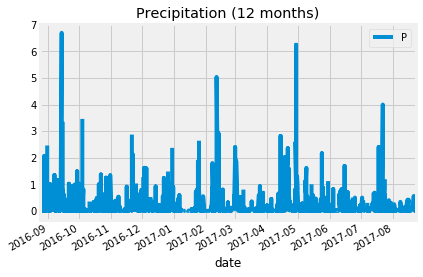

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date = max_date[0]


# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(query, columns = ['date', 'precipitation'])
# Sort the dataframe by date
prec_df['date'] = pd.to_datetime(prec_df['date'], format = '%Y-%m-%d')
prec_df.set_index('date', inplace = True)
prec_df = prec_df.sort_values(by = 'date', ascending = True)
# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(title = 'Precipitation (12 months)')
plt.legend('Precipitation')
plt.savefig('Images/PrecipitationAnalysis_Hawaii.png')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
#Get the column names from the table
columns = inspector.get_columns('Station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
#Get the distinct station count
loc_count = session.query(Station.station).distinct().count()
print(f'Stations Available: {loc_count}')

Stations Available: 9


In [16]:
# Group the stations and get a count of the rows from each station
active_stations = session.query(Measurement.station,func.count(Measurement.station))\
                    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
#Call on the first station with the most readings
most_active_station = active_stations[0][0]

In [18]:
#Get the values of min, max, and avg fromt he station with the most readings
active_stations_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
                        func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()


print(f'Low: {active_stations_temps[0][0]} High: {active_stations_temps[0][1]} Average: {(active_stations_temps[0][2])}')

Low: 54.0 High: 85.0 Average: 71.66378066378067


In [19]:
# Get the temperature from the station with the most frequencies and associated temps
temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter\
        (Measurement.station == most_active_station).filter(Measurement.date > year_ago).\
        order_by(Measurement.date).all()


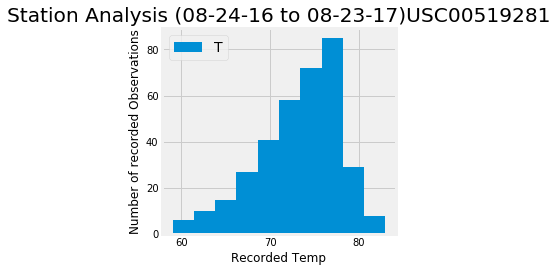

In [21]:
#putting data into pandas dataframe to plot
temp_df = pd.DataFrame(temp)

plt.hist(temp_df['tobs'])

plt.style.use('fivethirtyeight')
plt.xlabel('Recorded Temp')
plt.ylabel('Number of recorded Observations')
plt.title('Station Analysis (08-24-16 to 08-23-17)' + most_active_station)
plt.legend('Temp')
plt.tight_layout()
plt.savefig('Images/Temperature_Analysis.png')
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
trip = calc_temps('2017-01-01', '2017-03-01')
trip

[(59.0, 69.77333333333333, 81.0)]

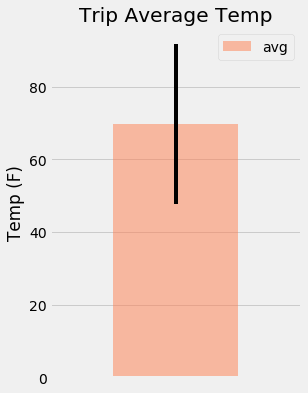

In [23]:
#Use calc_temps to find avg temperature and the yerr associated with the dataframe
trip_df = pd.DataFrame(trip, columns =['min', 'avg', 'max'])
trip_df.plot.bar(y = 'avg', yerr = (trip_df['min'] - trip_df['max']), title = 'Trip Average Temp',\
                 color = 'coral', alpha = 0.5, figsize = (4, 6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel('Temp (F)')
plt.savefig('Images/Average_Temp.png')

In [24]:
#Use a function to get station and precipitation information
def precipation(start_date, end_date):
    start = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end = dt.datetime.strptime(end_date, "%Y-%m-%d")
    
    rain_per_station = session.query(Station.name, Station.station, Station.latitude, Station.longitude,\
                                     Station.elevation, label('avg_rain',\
                                    func.avg(Measurement.prcp))).\
                                    filter(Measurement.station == Station.station).\
                                    filter(Measurement.date >= start).\
                                    filter(Measurement.date <= end).group_by(Station.name, Station.station).\
                                    order_by(func.avg(Measurement.prcp))
    df = pd.DataFrame(rain_per_station)
    return (df)



In [25]:
#Calling the function for the vacation dates
precipation('2017-01-01', '2017-03-01')

,name,station,latitude,longitude,elevation,avg_rain
0,"WAIKIKI 717.2, HI US",USC00519397,21.27160,-157.81680,3.0,0.089492
1,"PEARL CITY, HI US",USC00517948,21.39340,-157.97510,11.9,0.137895
2,"WAIHEE 837.5, HI US",USC00519281,21.45167,-157.84889,32.9,0.185424
3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,21.52130,-157.83740,7.0,0.186905
4,"KANEOHE 838.1, HI US",USC00513117,21.42340,-157.80150,14.6,0.188644
5,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,21.33556,-157.71139,19.5,0.224634
6,"MANOA LYON ARBO 785.2, HI US",USC00516128,21.33310,-157.80250,152.4,0.277273


In [26]:
#Create a function to get max, min, and avg for vacation days
def daily_normals(start_date, end_date):
    beg_date = dt.datetime.strptime(start_date, "%m-%d")
    last_date = start = dt.datetime.strptime(end_date, "%m-%d")
    
    beg_date = beg_date.replace(year = 2017)
    last_date = last_date.replace(year = 2017)
    
    daily_temps = session.query(Measurement.date, label('max', func.max(Measurement.tobs)),\
                               label('min', func.min(Measurement.tobs)), label('avg', func.avg\
                                (Measurement.tobs))).filter(Measurement.date >= beg_date).filter\
                                (Measurement.date <= last_date).group_by(Measurement.date).\
                                order_by(Measurement.date)
    
    daily_df = pd.DataFrame(daily_temps)
    daily_df = daily_df.set_index('date')
    
    return daily_df

In [27]:
#Calling the function
daily_normals('01-01', '03-01').head()

,max,min,avg
date,,,
2017-01-02,74.0,66.0,69.200000
2017-01-03,73.0,63.0,67.666667
2017-01-04,73.0,62.0,67.166667
2017-01-05,72.0,63.0,67.500000
2017-01-06,74.0,62.0,67.666667


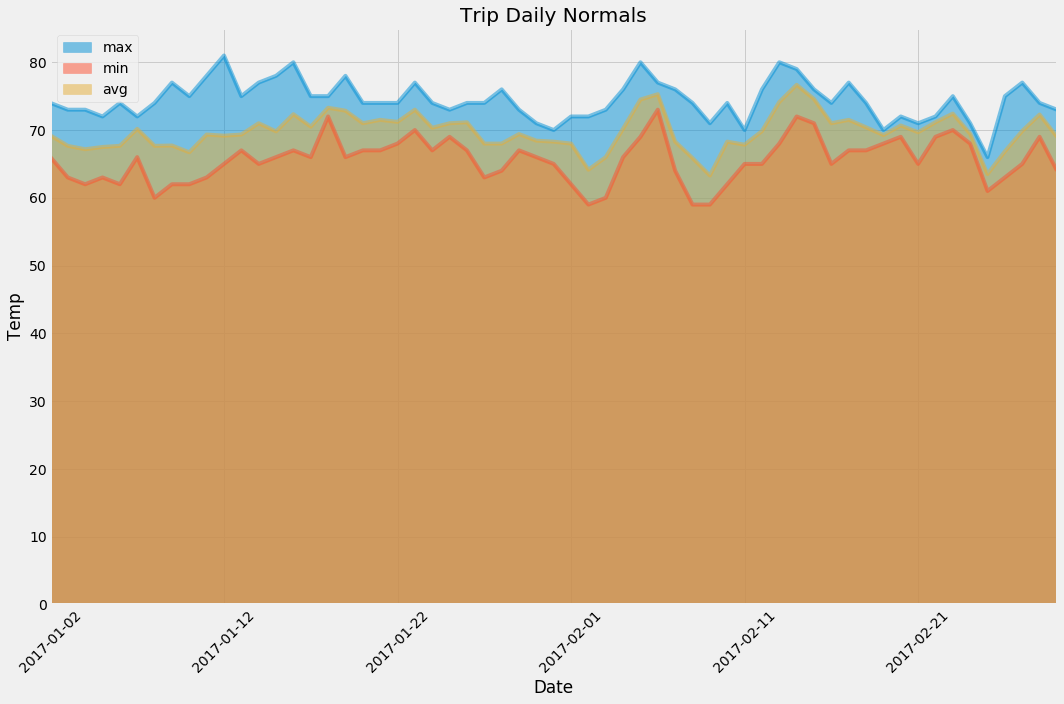

In [28]:
#Plotting the data from the dataframe to display the max, min, and avg for the vacation
#days
plot_df = daily_normals('01-01', '03-01')
plot_df.plot(kind='area', stacked = False, figsize=(15, 10))

plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Trip Daily Normals')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig('Images/Daily_Temp.png')
plt.show()